# Importing Necessary Libraries

In [74]:
import itertools
## Regular Expression
import re

## Arrays
import numpy as np

## DataFrames
import pandas as pd

## Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier

import contractions
import spacy
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

## Warnings
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

In [75]:
pd.set_option('max_columns',40)

# Reading the File

In [76]:
df = pd.read_csv('Cleaned_Women_ECommerce.csv')

# Natural Language Processing

In [77]:
df.head(3)

,Unnamed: 0,clothing_id,age,review_text,rating,recommended_ind,positive_feedback_count,division_name,department_name,class_name,new_text,clean_text,review_length,rating_class,tokens
0,0,767,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and comf...,absolutely wonderful silky sexy comfortable,45,good,"['absolutely', 'wonderful', 'silky', 'sexy', '..."
1,1,1080,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happene...,love dress sooo pretty happened find store...,195,good,"['love', 'dress', 'sooo', 'pretty', 'happened'..."
2,2,1077,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,major design flaw high hope dress really wante...,338,neutral,"['major', 'design', 'flaw', 'high', 'hope', 'd..."


In [78]:
df.drop('Unnamed: 0',axis = 1, inplace=True)

# Since there were not too many distinguiser words in different classes, the most and least common 70 words added to the stopwords list and Logistic Regression Model was applied again.

# Words and Frequencies

In [79]:
cleaned_text = [str(txt) for text in df['clean_text'] for txt in text.split(' ') if len(txt)>2 and txt not in 'not, nan']
word_dist = nltk.FreqDist(cleaned_text)

# Adding the Most Common and the Least Common 70 Words to the Stopwords List

In [80]:
stopword_list= stopwords.words('english')
stopword_list= stopwords.words('english')
for y in word_dist.most_common()[-70:]:
    stopword_list.append(y[0])
mst_c = word_dist.most_common()[:70]
for x in mst_c:
    stopword_list.append(x[0])

In [81]:
print(len(stopword_list))

319


In [82]:
lemmatizer = WordNetLemmatizer()

In [83]:
# Applying the new stopwords List to the Clean Text Column

In [84]:
df['clean_text'] = df['clean_text'].map(lambda text: " ".join([lemmatizer.lemmatize(w) for w in text.split(' ') if w not in stopword_list]))

# Splitting the Data Set into Train and Test Sets

In [85]:
text = df['clean_text']
target = df['rating_class']
X_train, X_test, y_train, y_test = train_test_split(text, target, test_size=0.25, random_state=5)

# Count Vectorizing

In [86]:
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.999)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

# Vocabulary Length and The Longest Word

In [87]:
print('Vocabulary len :', len(count_vect.get_feature_names()))
print('Longest word   :', max(count_vect.vocabulary_, key=len))

Vocabulary len : 1919
Longest word   : disappointment


# Confusion Matrix Plot Function

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.summer):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

# Logistic Regression with Count Vectorizing

In [89]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=0.1, n_jobs=-1, random_state=5)
logreg_CV.fit(count_vect_train, y_train)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.7689588120912144


 ### Classification Report

In [90]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.44      0.57      0.50       600
       good       0.95      0.84      0.89      4376
    neutral       0.32      0.46      0.38       681

avg / total       0.82      0.77      0.79      5657



### Confusion Matrix

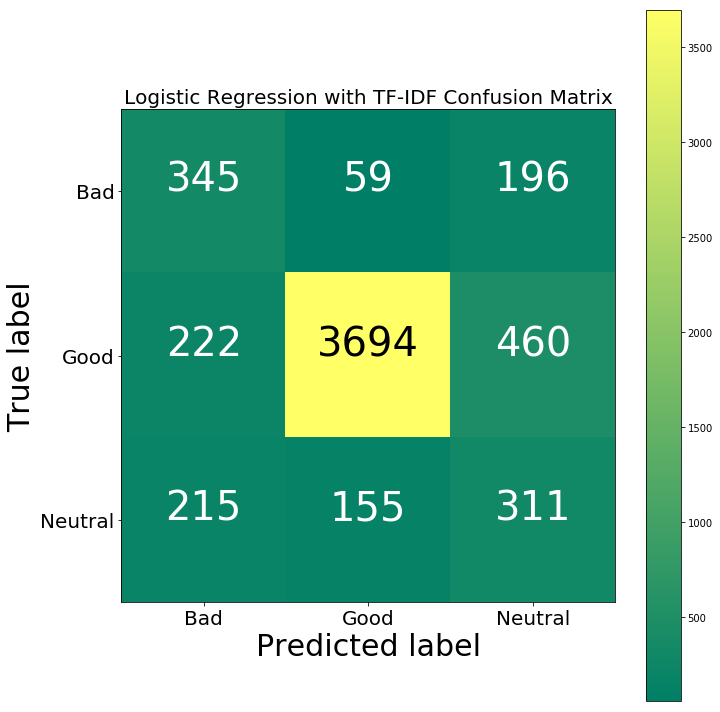

[[ 345   59  196]
 [ 222 3694  460]
 [ 215  155  311]]


In [91]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Logistic Regression with TF-IDF Confusion Matrix')
plt.show()
print(cm)

# Logistic Regression Train Set Accurayc Report

In [92]:
print('Accuracy :', metrics.accuracy_score(y_train, logreg_CV.predict(count_vect_train)))

Accuracy : 0.8429674150020623


# Logistic Regression Train Set Accurayc Report

In [93]:
print(classification_report(y_train, logreg_CV.predict(count_vect_train)))

             precision    recall  f1-score   support

        bad       0.63      0.81      0.71      1770
       good       0.97      0.86      0.92     13059
    neutral       0.51      0.74      0.61      2142

avg / total       0.88      0.84      0.86     16971



# Linear SVM 

In [94]:
ln_SVM_CV = LinearSVC(random_state=5)
ln_SVM_CV.fit(count_vect_train, y_train)
y_pred_SVM_CV = ln_SVM_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_SVM_CV))

Accuracy : 0.8041364680926286


In [95]:
print (classification_report(y_test, y_pred_SVM_CV))

             precision    recall  f1-score   support

        bad       0.51      0.45      0.48       600
       good       0.88      0.94      0.91      4376
    neutral       0.36      0.24      0.28       681

avg / total       0.78      0.80      0.79      5657



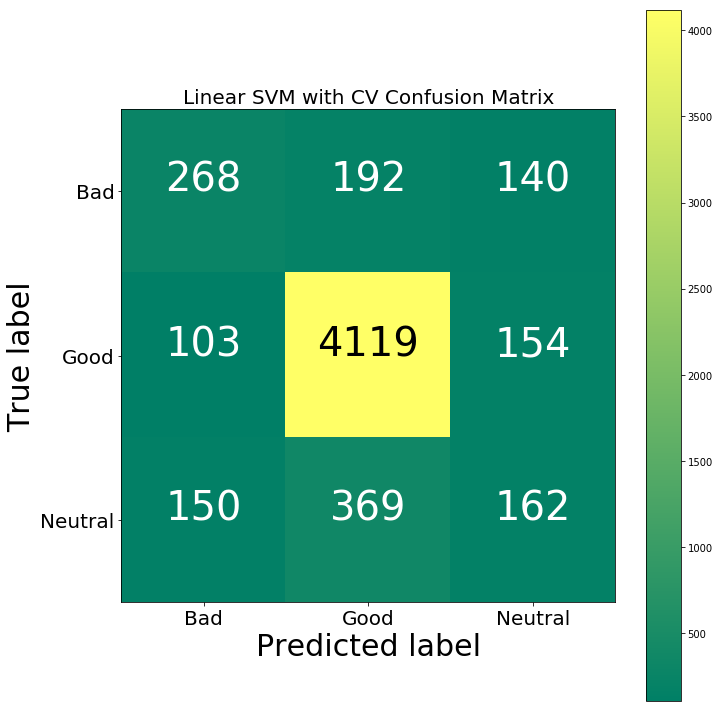

[[ 268  192  140]
 [ 103 4119  154]
 [ 150  369  162]]


In [96]:
cm = confusion_matrix(y_test, y_pred_SVM_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Linear SVM with CV Confusion Matrix')
plt.show()
print(cm)

# Random Forest

In [97]:
rf_CV = RandomForestClassifier(random_state=5)
rf_CV.fit(count_vect_train, y_train)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.7898179246950681


In [98]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.49      0.36      0.42       600
       good       0.84      0.96      0.89      4376
    neutral       0.31      0.10      0.15       681

avg / total       0.74      0.79      0.75      5657



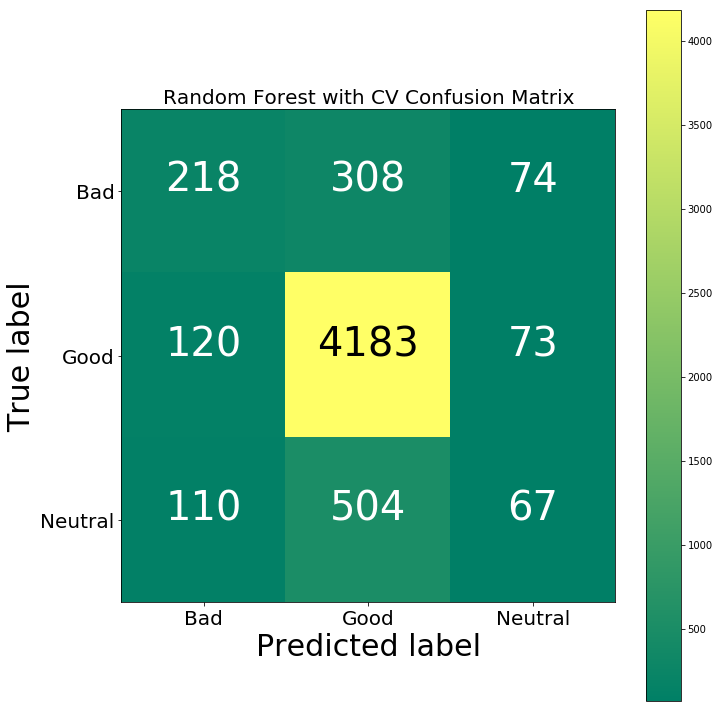

[[ 218  308   74]
 [ 120 4183   73]
 [ 110  504   67]]


In [99]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Random Forest with CV Confusion Matrix')
plt.show()
print(cm)

# Gradient Boosting Regressor

In [100]:
gb_boost_cv = GradientBoostingClassifier()
gb_boost_cv.fit(count_vect_train, y_train)
y_pred_gb_boost = gb_boost_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_gb_boost))

Accuracy : 0.7974191267456249


In [101]:
print (classification_report(y_test, y_pred_gb_boost))

             precision    recall  f1-score   support

        bad       0.62      0.22      0.33       600
       good       0.82      0.99      0.89      4376
    neutral       0.41      0.09      0.15       681

avg / total       0.75      0.80      0.74      5657



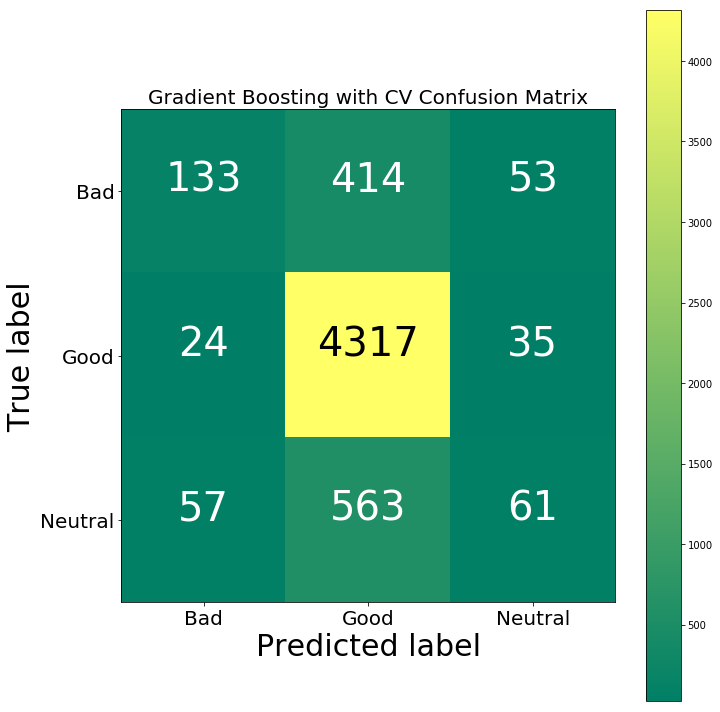

[[ 133  414   53]
 [  24 4317   35]
 [  57  563   61]]


In [102]:
cm = confusion_matrix(y_test, y_pred_gb_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Gradient Boosting with CV Confusion Matrix')
plt.show()
print(cm)

# Xg Boosting Regressor

In [103]:
xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(count_vect_train, y_train)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.7931765953685699


In [104]:
print (classification_report(y_test, y_pred_xg_boost))

             precision    recall  f1-score   support

        bad       0.62      0.18      0.28       600
       good       0.81      0.99      0.89      4376
    neutral       0.42      0.06      0.10       681

avg / total       0.74      0.79      0.73      5657



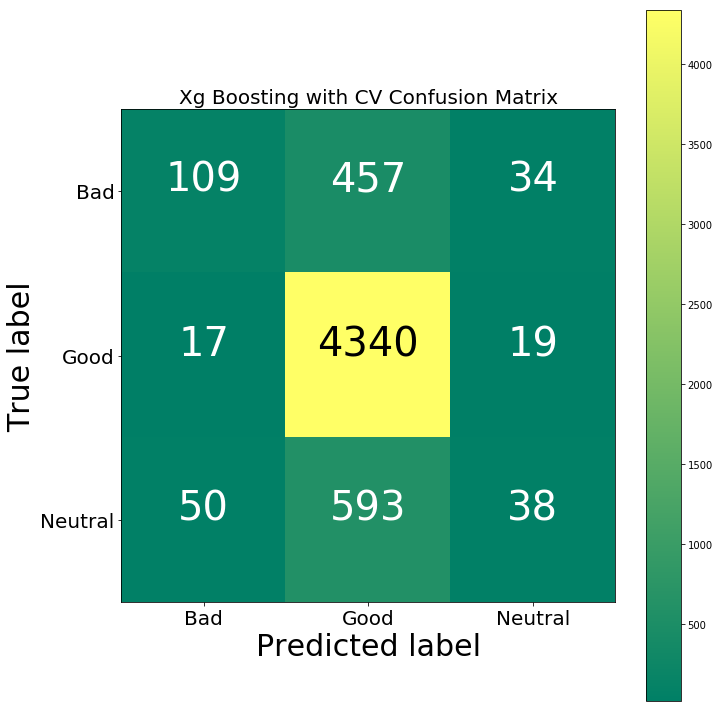

[[ 109  457   34]
 [  17 4340   19]
 [  50  593   38]]


In [105]:
cm = confusion_matrix(y_test, y_pred_xg_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Xg Boosting with CV Confusion Matrix')
plt.show()
print(cm)

# Naive Bayes with CV

In [106]:
MulNB_CV = MultinomialNB()
MulNB_CV.fit(count_vect_train, y_train)

y_pred_nb_CV = MulNB_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test,y_pred_nb_CV ))

Accuracy : 0.8037829238112073


In [107]:
print (classification_report(y_test, y_pred_nb_CV))

             precision    recall  f1-score   support

        bad       0.55      0.52      0.53       600
       good       0.92      0.90      0.91      4376
    neutral       0.36      0.44      0.40       681

avg / total       0.82      0.80      0.81      5657



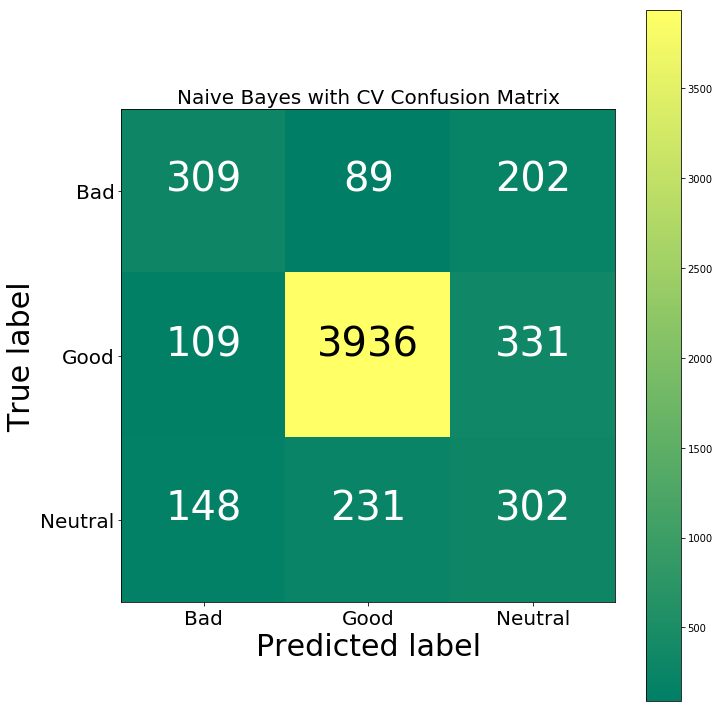

[[ 309   89  202]
 [ 109 3936  331]
 [ 148  231  302]]


In [108]:
cm = confusion_matrix(y_test, y_pred_nb_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Naive Bayes with CV Confusion Matrix')
plt.show()
print(cm)

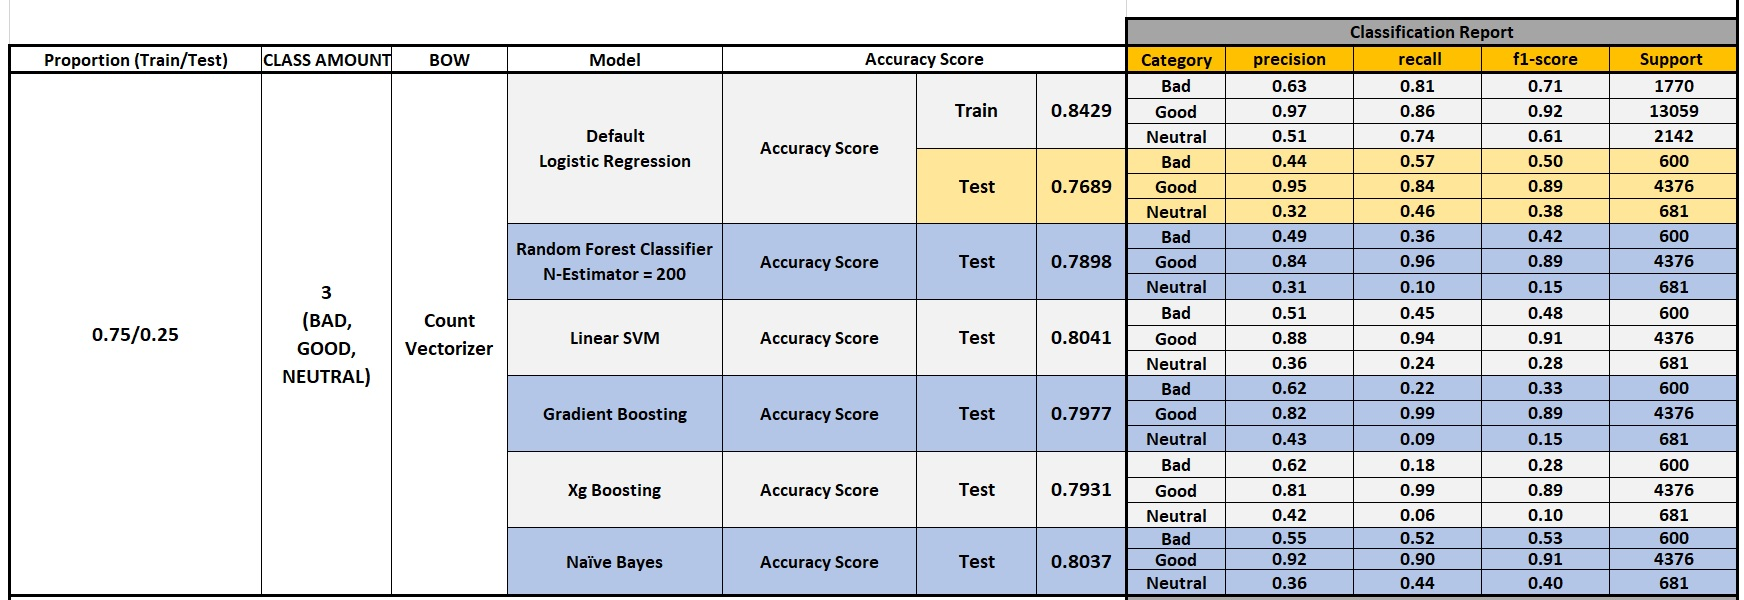

In [109]:
from IPython.display import Image
img = 'Stopwords.jpg'
Image(filename=img)

# Synthetic Minority Oversampling Technique (SMOTE)

In [110]:
from collections import Counter
from imblearn.over_sampling import SMOTE 
sm = SMOTE(ratio = 'minority',random_state=5)
df_text, df_target = sm.fit_sample(count_vect_train, y_train)
#print (count_vect_train.value_counts(), np.bincount(df_target))
print (df_text.shape)
print (df_target.shape)

(28260, 1919)
(28260,)


In [111]:
from collections import Counter
Counter(df_target)

Counter({'bad': 13059, 'good': 13059, 'neutral': 2142})

# Logistic Regression

In [112]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C=0.1, n_jobs=-1, random_state=5)
logreg_CV.fit(df_text, df_target)
y_pred_lr_CV = logreg_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.7518119144422839


In [113]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.39      0.53      0.45       600
       good       0.94      0.83      0.88      4376
    neutral       0.32      0.48      0.38       681

avg / total       0.81      0.75      0.77      5657



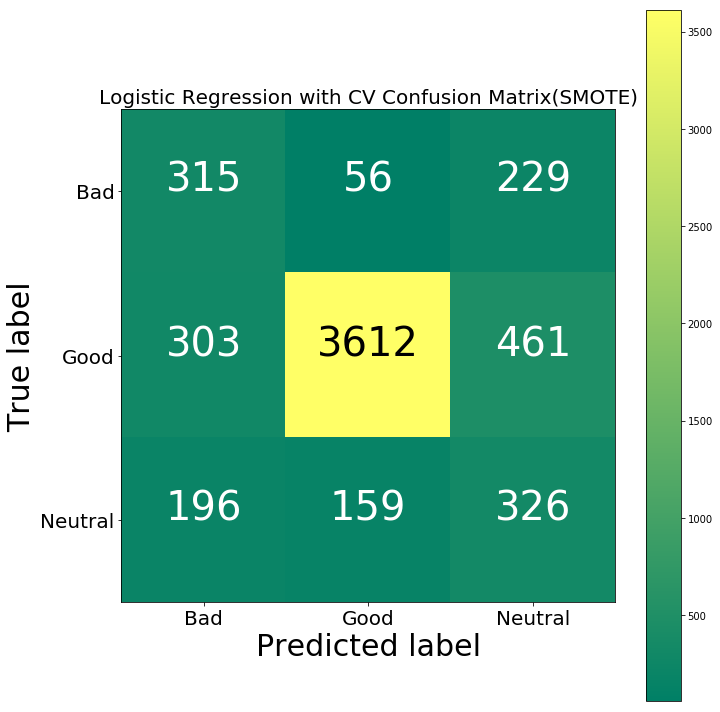

[[ 315   56  229]
 [ 303 3612  461]
 [ 196  159  326]]


In [114]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Logistic Regression with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Train Set Accuracy Report

In [115]:
print('Accuracy :', metrics.accuracy_score(df_target, logreg_CV.predict(df_text)))

Accuracy : 0.8561571125265393


# Train Set Classification Report

In [116]:
print (classification_report(df_target, logreg_CV.predict(df_text)))

             precision    recall  f1-score   support

        bad       0.92      0.87      0.89     13059
       good       0.96      0.85      0.90     13059
    neutral       0.39      0.78      0.52      2142

avg / total       0.90      0.86      0.87     28260



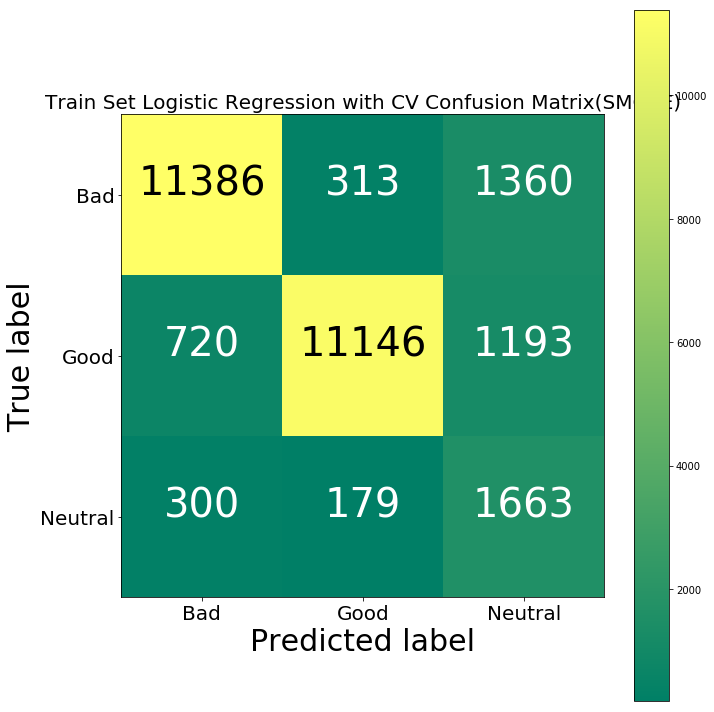

[[11386   313  1360]
 [  720 11146  1193]
 [  300   179  1663]]


In [117]:
cm = confusion_matrix(df_target, logreg_CV.predict(df_text))
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Train Set Logistic Regression with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# K NNeighbors Classifier

In [118]:
from sklearn.neighbors import KNeighborsClassifier

In [119]:
neigh_CV = KNeighborsClassifier(n_neighbors=5, n_jobs = -1)
neigh_CV.fit(df_text, df_target)
y_pred_kn_CV = neigh_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_kn_CV))

Accuracy : 0.6362029344175358


In [120]:
print (classification_report(y_test, y_pred_kn_CV))

             precision    recall  f1-score   support

        bad       0.21      0.69      0.32       600
       good       0.87      0.73      0.79      4376
    neutral       0.30      0.00      0.01       681

avg / total       0.73      0.64      0.65      5657



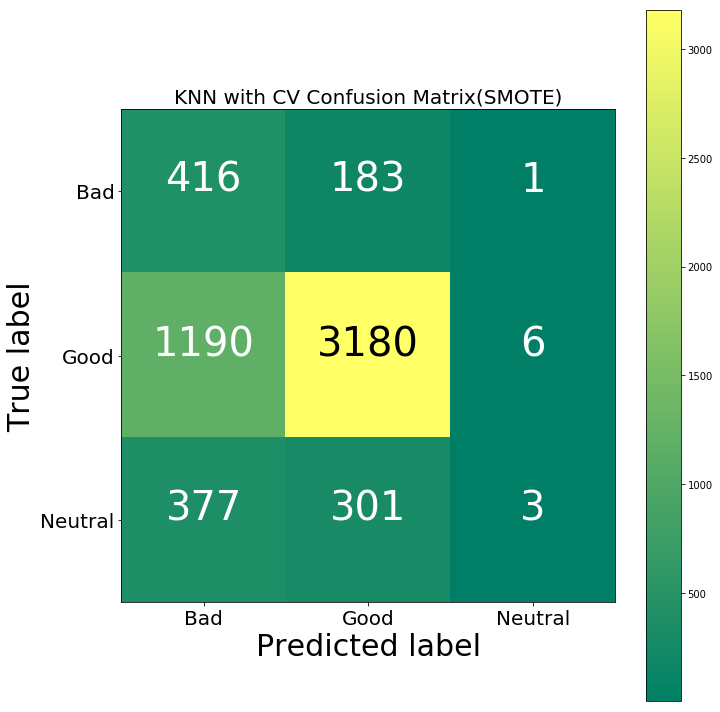

[[ 416  183    1]
 [1190 3180    6]
 [ 377  301    3]]


In [121]:
cm = confusion_matrix(y_test, y_pred_kn_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='KNN with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Random Forest

In [122]:
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(df_text, df_target)
y_pred_rf_CV = rf_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.7991868481527311


In [123]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.54      0.34      0.42       600
       good       0.82      0.98      0.89      4376
    neutral       0.44      0.01      0.02       681

avg / total       0.74      0.80      0.74      5657



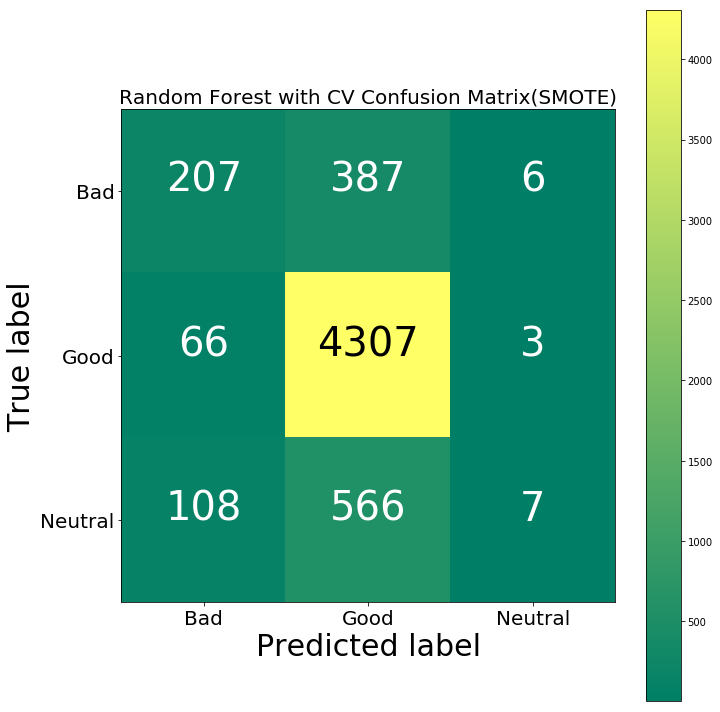

[[ 207  387    6]
 [  66 4307    3]
 [ 108  566    7]]


In [124]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Random Forest with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Linear SVM

In [125]:
ln_SVM_CV = LinearSVC(random_state=5)
ln_SVM_CV.fit(df_text, df_target)
y_pred_SVM_CV = ln_SVM_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_SVM_CV))

Accuracy : 0.7753226091567968


In [126]:
print (classification_report(y_test, y_pred_SVM_CV))

             precision    recall  f1-score   support

        bad       0.38      0.65      0.48       600
       good       0.90      0.89      0.90      4376
    neutral       0.33      0.13      0.19       681

avg / total       0.77      0.78      0.77      5657



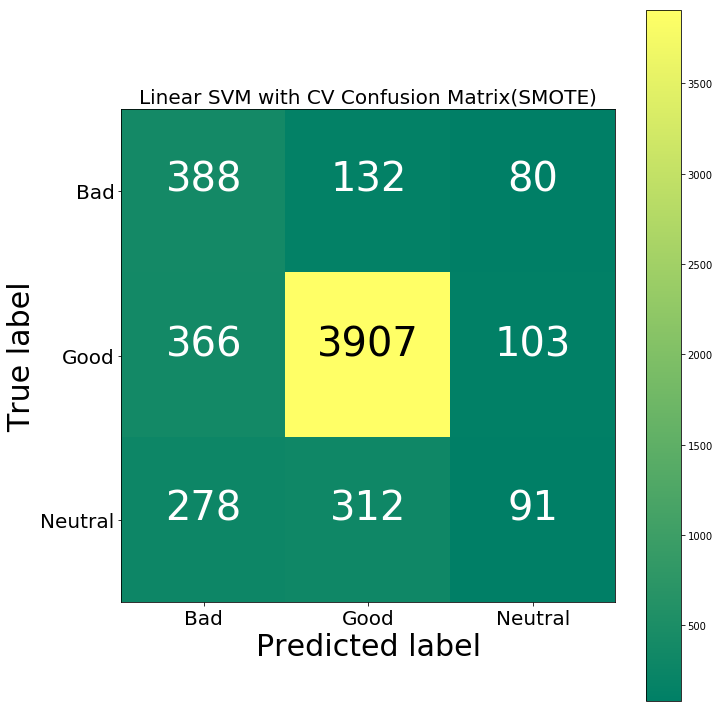

[[ 388  132   80]
 [ 366 3907  103]
 [ 278  312   91]]


In [127]:
cm = confusion_matrix(y_test, y_pred_SVM_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Linear SVM with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Gradient Boosting Regressor

In [128]:
gb_boost_cv = GradientBoostingClassifier()
gb_boost_cv.fit(df_text, df_target)
y_pred_gb_boost = gb_boost_cv.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_gb_boost))

Accuracy : 0.8030758352483649


In [129]:
print (classification_report(y_test, y_pred_gb_boost))

             precision    recall  f1-score   support

        bad       0.50      0.42      0.46       600
       good       0.84      0.97      0.90      4376
    neutral       0.43      0.06      0.11       681

avg / total       0.75      0.80      0.76      5657



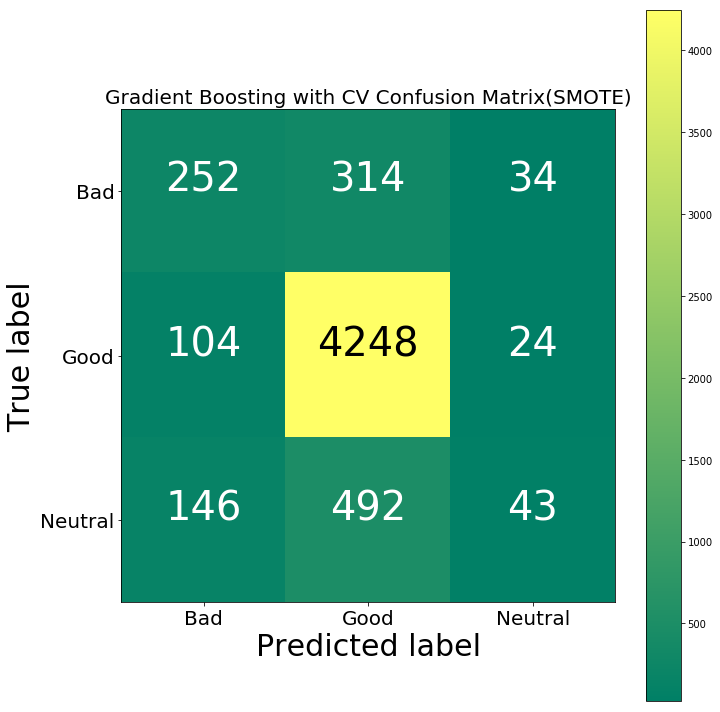

[[ 252  314   34]
 [ 104 4248   24]
 [ 146  492   43]]


In [130]:
cm = confusion_matrix(y_test, y_pred_gb_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Gradient Boosting with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Xg Boosting

In [131]:
xg_boost_CV = XGBClassifier()
xg_boost_CV.fit(df_text, df_target)
y_pred_xg_boost = xg_boost_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_xg_boost))

Accuracy : 0.798302987449178


In [132]:
print (classification_report(y_test, y_pred_xg_boost))

             precision    recall  f1-score   support

        bad       0.46      0.45      0.46       600
       good       0.84      0.97      0.90      4376
    neutral       0.44      0.03      0.06       681

avg / total       0.75      0.80      0.75      5657



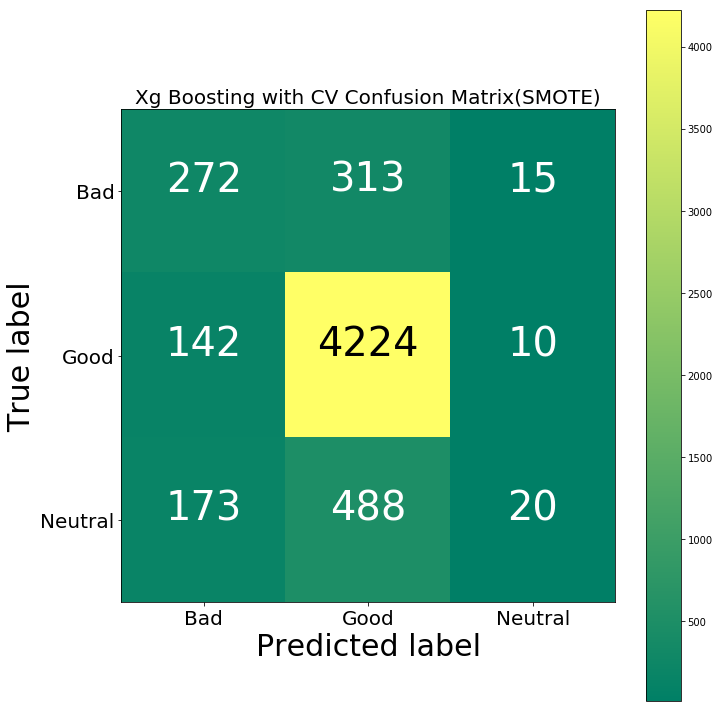

[[ 272  313   15]
 [ 142 4224   10]
 [ 173  488   20]]


In [133]:
cm = confusion_matrix(y_test, y_pred_xg_boost)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Xg Boosting with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

# Naive Bayes

In [134]:
MulNB_CV = MultinomialNB()
MulNB_CV.fit(df_text, df_target)

y_pred_nb_CV = MulNB_CV.predict(count_vect_test)
print('Accuracy :', metrics.accuracy_score(y_test,y_pred_nb_CV))

Accuracy : 0.7785045076895881


In [135]:
print (classification_report(y_test, y_pred_nb_CV))

             precision    recall  f1-score   support

        bad       0.40      0.73      0.52       600
       good       0.94      0.87      0.90      4376
    neutral       0.34      0.26      0.30       681

avg / total       0.81      0.78      0.79      5657



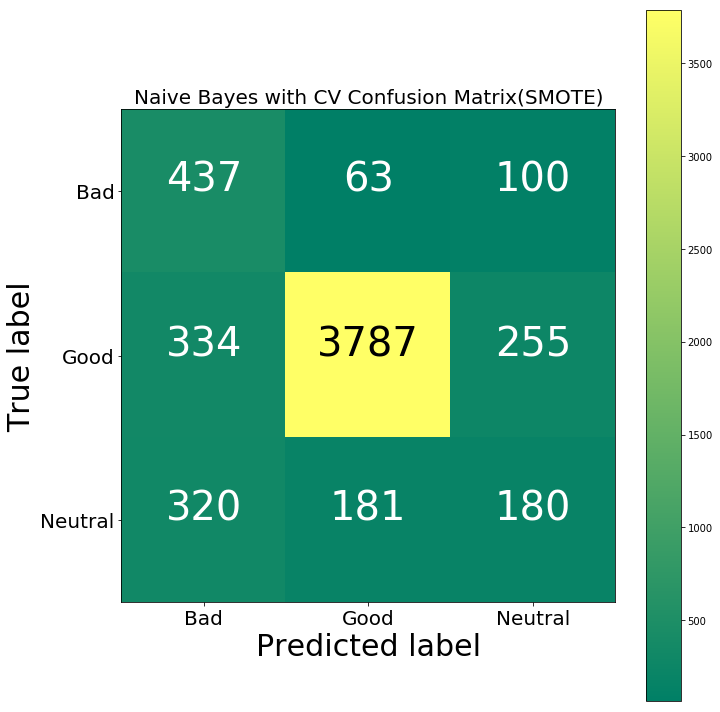

[[ 437   63  100]
 [ 334 3787  255]
 [ 320  181  180]]


In [136]:
cm = confusion_matrix(y_test, y_pred_nb_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Naive Bayes with CV Confusion Matrix(SMOTE)')
plt.show()
print(cm)

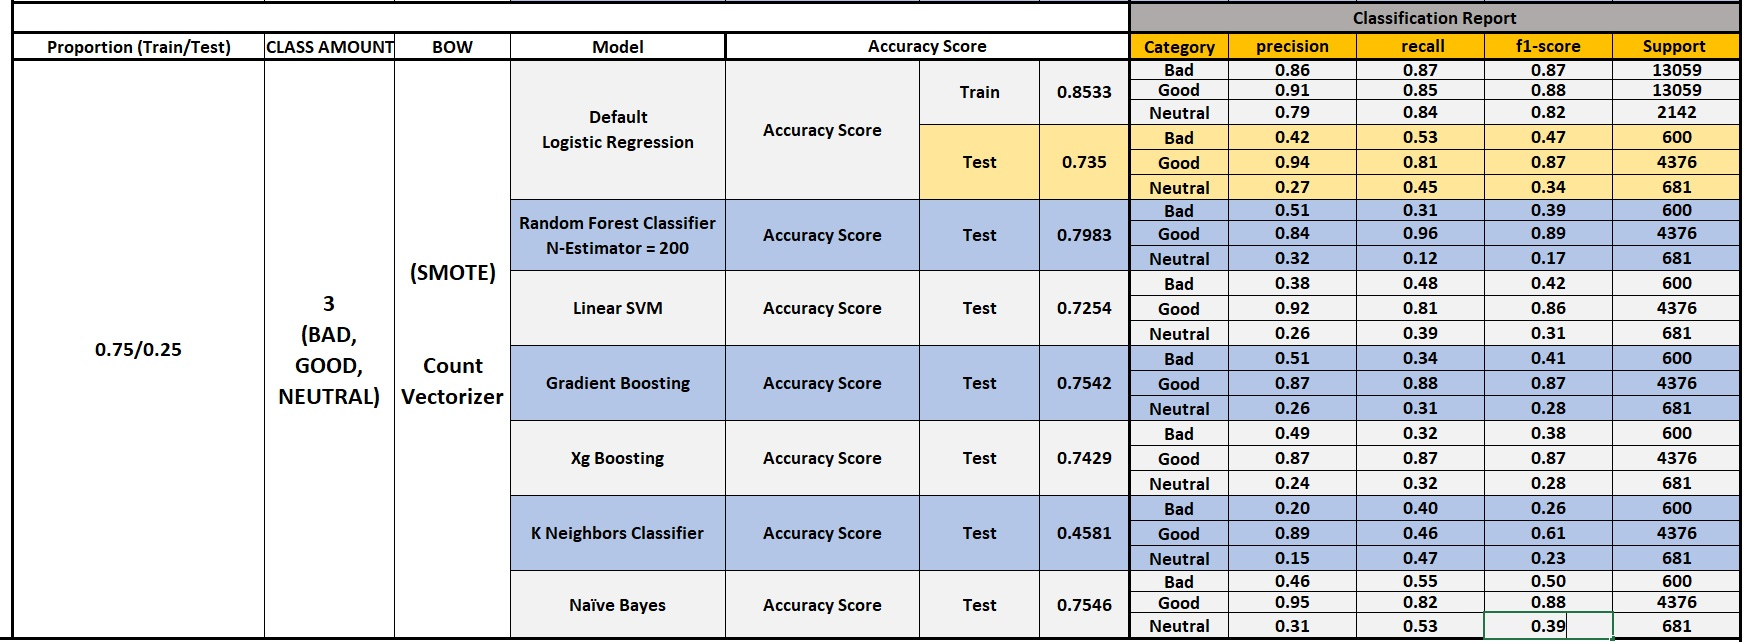

In [137]:
img = 'Stopwords_SMOTE.jpg'
Image(filename=img)

# Applying PCA to Decrease the Linear Dimentionality (Fit-Transform)

In [138]:
from sklearn.decomposition import PCA
count_vect = CountVectorizer(ngram_range=(1,1), min_df=0.001, max_df=0.975)
pca = PCA(n_components=800, random_state=5)
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
pca_X_train = pca.fit_transform(count_vect_train)



count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()
pca_X_test = pca.fit_transform(count_vect_test)

In [139]:
sm = SMOTE(ratio = 'minority', random_state=5)
df_text, df_target = sm.fit_sample(pca_X_train, y_train)
#print (count_vect_train.value_counts(), np.bincount(df_target))
print (df_text.shape)
print (df_target.shape)

(28260, 800)
(28260,)


In [140]:
from collections import Counter
Counter(df_target)

Counter({'bad': 13059, 'good': 13059, 'neutral': 2142})

# Logistic Regression (CV&PCA&SMOTE)

In [141]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              C = 0.1, n_jobs=-1, random_state=5)
logreg_CV.fit(df_text, df_target)
y_pred_lr_CV = logreg_CV.predict(pca_X_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.48205762771787164


In [142]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.13      0.18      0.15       600
       good       0.76      0.57      0.65      4376
    neutral       0.09      0.19      0.12       681

avg / total       0.61      0.48      0.53      5657



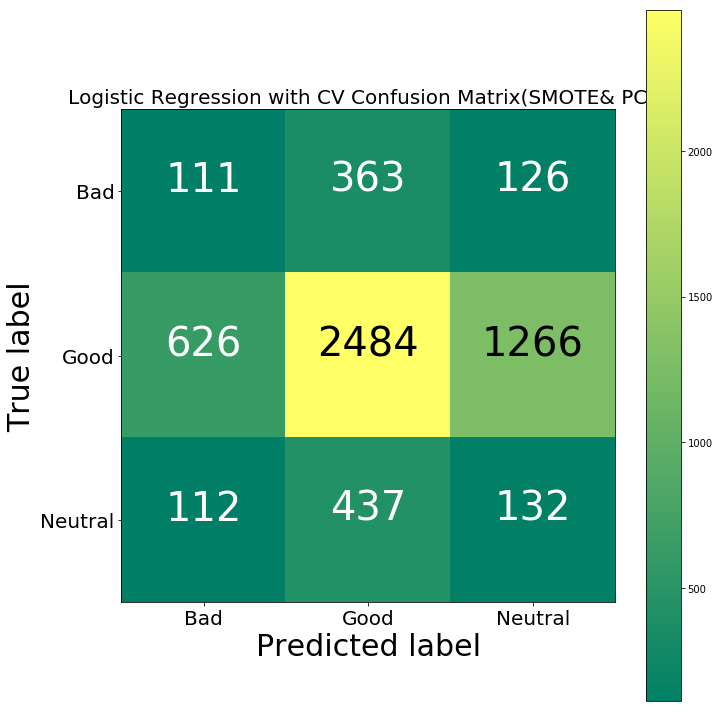

[[ 111  363  126]
 [ 626 2484 1266]
 [ 112  437  132]]


In [143]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Logistic Regression with CV Confusion Matrix(SMOTE& PCA)')
plt.show()
print(cm)

# Random Forest (CV&PCA&SMOTE)

In [144]:
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(df_text, df_target)
y_pred_rf_CV = rf_CV.predict(pca_X_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.6955983736963055


In [145]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.08      0.07      0.08       600
       good       0.77      0.89      0.82      4376
    neutral       0.00      0.00      0.00       681

avg / total       0.60      0.70      0.64      5657



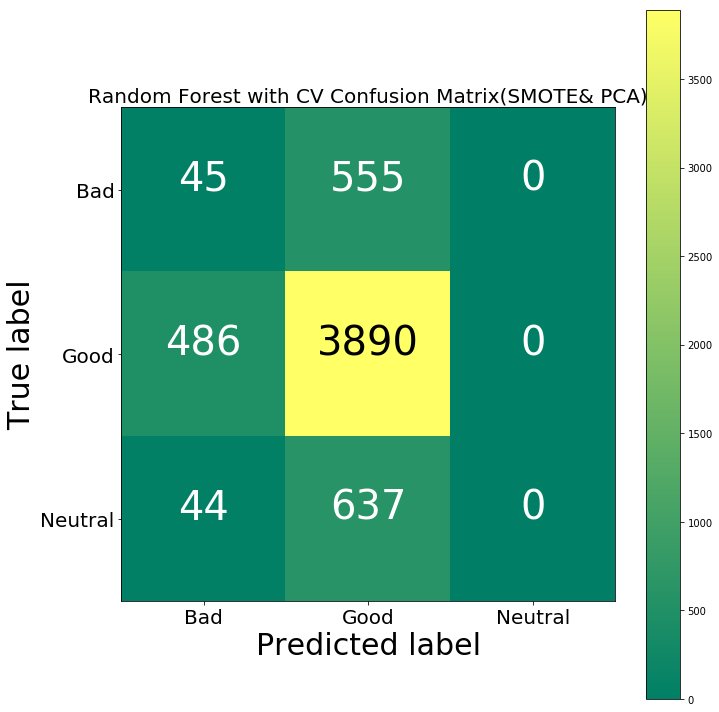

[[  45  555    0]
 [ 486 3890    0]
 [  44  637    0]]


In [146]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Random Forest with CV Confusion Matrix(SMOTE& PCA)')
plt.show()
print(cm)

# Truncated SVD

In [147]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=800, random_state=5)
svd_X_train = svd.fit_transform(count_vect_train)
svd_X_test = svd.fit_transform(count_vect_test)

# SMOTE

In [148]:
sm = SMOTE(ratio = 'minority', random_state=5)
df_ttext, df_ttarget = sm.fit_sample(svd_X_train, y_train)
#print (count_vect_train.value_counts(), np.bincount(df_target))
print (df_ttext.shape)
print (df_ttarget.shape)

(28260, 800)
(28260,)


In [149]:
from collections import Counter
Counter(df_ttarget)

Counter({'bad': 13059, 'good': 13059, 'neutral': 2142})

# Logistic Regression(CV&TRUNCATED SVD & SMOTE)

In [150]:
logreg_CV = LogisticRegression(multi_class='multinomial', solver='newton-cg',class_weight='balanced',
                              n_jobs=-1, random_state=5)
logreg_CV.fit(df_ttext, df_ttarget)
y_pred_lr_CV = logreg_CV.predict(svd_X_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_lr_CV))

Accuracy : 0.533144776383242


In [151]:
print (classification_report(y_test, y_pred_lr_CV))

             precision    recall  f1-score   support

        bad       0.12      0.23      0.16       600
       good       0.81      0.61      0.70      4376
    neutral       0.16      0.28      0.21       681

avg / total       0.66      0.53      0.58      5657



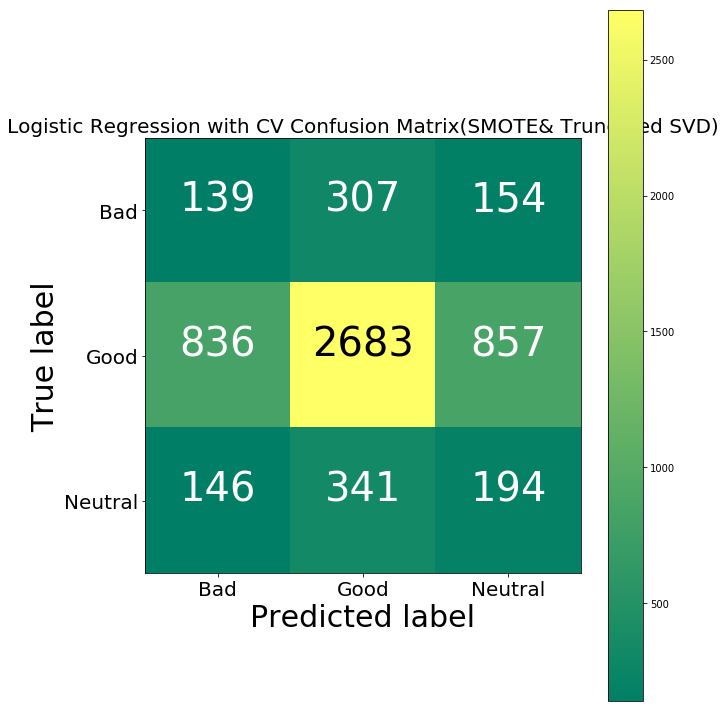

[[ 139  307  154]
 [ 836 2683  857]
 [ 146  341  194]]


In [152]:
cm = confusion_matrix(y_test, y_pred_lr_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Logistic Regression with CV Confusion Matrix(SMOTE& Truncated SVD)')
plt.show()
print(cm)

# Random Forest (CV & TRUNCATED SVD & SMOTE)

In [153]:
rf_CV = RandomForestClassifier(n_estimators = 200, random_state=5)
rf_CV.fit(df_ttext, df_ttarget)
y_pred_rf_CV = rf_CV.predict(svd_X_test)
print('Accuracy :', metrics.accuracy_score(y_test, y_pred_rf_CV))

Accuracy : 0.7275941311649284


In [154]:
print (classification_report(y_test, y_pred_rf_CV))

             precision    recall  f1-score   support

        bad       0.06      0.04      0.05       600
       good       0.77      0.94      0.84      4376
    neutral       0.00      0.00      0.00       681

avg / total       0.60      0.73      0.66      5657



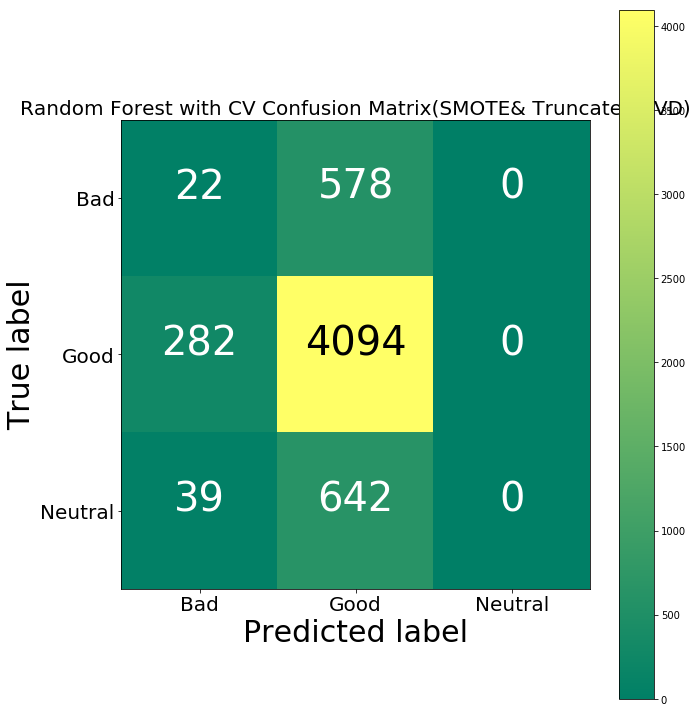

[[  22  578    0]
 [ 282 4094    0]
 [  39  642    0]]


In [155]:
cm = confusion_matrix(y_test, y_pred_rf_CV)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Bad','Good','Neutral'], normalize=False, title='Random Forest with CV Confusion Matrix(SMOTE& Truncated SVD)')
plt.show()
print(cm)

### Without adding the most and least common 70 words to the stopwords list, bad and neutral precision and recall are slightly low. Most probable reason is that there are no too much characteristic words to distinguish the classes. After adding the common words to the stopwords list, neutral and bad precision and recall increased almost 3 times. SMOTE did not effect the accuracy of the models too much and Linear Dimentionality Reduction (PCA and TruncatedSVD) decreased the accuracy of the models. 